In [1]:
# import tensorflow.compat.v1 as tf
import tensorflow as tf
import numpy as np
import os
import PIL.Image
from matplotlib import pylab as P
import functools
import sys
import pandas as pd

%matplotlib inline


In [2]:
tf.__version__


'1.15.0'

In [3]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

In [4]:
ViewLabel_to_Name_mapping = {0: "PLAX", 1: "PSAX", 2: "A4C", 3: "A2C", 4:"Useful_Unlabeled", -1:"Not_Provided"}
DiagnosisLabel_to_Name_mapping = {0: "no_AS", 1: "early_AS", 2: "significant_AS", -1: "Not_Provided"}


### Utility methods

In [5]:
def normalize_to_be_the_same_value_seen_by_model(image):
    
    image = image[:,:,np.newaxis] * 2.0 /255 - 1.0
    
    return image

In [6]:
# Boilerplate methods

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    
    P.imshow(im , cmap=P.cm.gray, vmin=0, vmax=1) #im is of float, 0-1

    P.title(title)

    
def LoadImage(file_path):
    im = PIL.Image.open(file_path)
    im = np.asarray(im)
    return im
    
 

In [7]:
def getter_ema(ema, getter, name, *args, **kwargs):
    """Exponential moving average getter for variable scopes.

    Args:
        ema: ExponentialMovingAverage object, where to get variable moving averages.
        getter: default variable scope getter.
        name: variable name.
        *args: extra args passed to default getter.
        **kwargs: extra args passed to default getter.

    Returns:
        If found the moving average variable, otherwise the default variable.
    """
    var = getter(name, *args, **kwargs)
    ema_var = ema.average(var)
    return ema_var if ema_var else var

In [8]:
def model_vars(scope=None):
    return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope)

### Construct model

### View, fs

In [9]:
dataset_mean = 0
dataset_std = 1
nclass = 5

In [10]:
hwc = [112, 112, 1]
scales = 4
filters = 32
repeat = 4
training = False 

In [11]:
def classifier(x, scales, filters, repeat, training, dropout_rate=0.1, getter=None, **kwargs):
    del kwargs
    leaky_relu = functools.partial(tf.nn.leaky_relu, alpha=0.1)
    bn_args = dict(training=training, momentum=0.999)

    def conv_args(k, f):
        return dict(padding='same',
                    kernel_initializer=tf.random_normal_initializer(stddev=tf.rsqrt(0.5 * k * k * f)))

    def residual(x0, filters, stride=1, activate_before_residual=False):
        x = leaky_relu(tf.layers.batch_normalization(x0, **bn_args))
        if activate_before_residual:
            x0 = x

        x = tf.layers.conv2d(x, filters, 3, strides=stride, **conv_args(3, filters))
        x = leaky_relu(tf.layers.batch_normalization(x, **bn_args))
        x = tf.layers.dropout(x, rate=dropout_rate, training=training) #20211109: hz add dropout
        x = tf.layers.conv2d(x, filters, 3, **conv_args(3, filters))

        if x0.get_shape()[3] != filters:
            x0 = tf.layers.conv2d(x0, filters, 1, strides=stride, **conv_args(1, filters))

        return x0 + x

    with tf.variable_scope('classify', reuse=tf.AUTO_REUSE, custom_getter=getter):
        y = tf.layers.conv2d((x - dataset_mean) / dataset_std, 16, 3, **conv_args(3, 16))
        for scale in range(scales):
            y = residual(y, filters << scale, stride=2 if scale else 1, activate_before_residual=scale == 0)
            for i in range(repeat - 1):
                y = residual(y, filters << scale)

        y = leaky_relu(tf.layers.batch_normalization(y, **bn_args))
        y = tf.reduce_mean(y, [1, 2])
        logits = tf.layers.dense(y, nclass, kernel_initializer=tf.glorot_normal_initializer())
    return logits

### Create graph and load pretrained weights


In [12]:
model_path = '/cluster/tufts/hugheslab/zhuang12/JACC_CodeRelease/Echo_TMEDV2/checkpoints/view/fs/seed0'

# tf.reset_default_graph()
graph2 = tf.Graph()
sess2 = tf.Session(graph=graph2)
with graph2.as_default():
    x_in_view = tf.placeholder(tf.float32, [None] + hwc, 'x') #labeled images, after augmentation operation in data_pair.py
    logits_view = classifier(x_in_view, scales, filters, repeat, training, getter=None)

    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_op = ema.apply(model_vars())
    ema_getter = functools.partial(getter_ema, ema)
    
    classify_op_view = tf.nn.softmax(classifier(x_in_view, scales, filters, repeat, getter=ema_getter, training=False))
    
    saver = tf.train.Saver()
    saver.restore(sess2, os.path.join(model_path,'best_balanced_validation_accuracy_ema.ckpt'))

INFO:tensorflow:Restoring parameters from /cluster/tufts/hugheslab/zhuang12/JACC_CodeRelease/Echo_TMEDV2/checkpoints/view/fs/seed0/best_balanced_validation_accuracy_ema.ckpt


### Load the xxx_foldx.csv

In [13]:
JACC_fold0_csv = pd.read_csv('/cluster/tufts/hugheslab/zhuang12/JACC_DataRelease/20220412version/SplitImageLabelMapping/release/JACC_fold0.csv')


In [14]:
JACC_fold0_csv

,query_key,view_classifier_split,diagnosis_classifier_split,view_label,diagnosis_label
0,4860s1_0.png,train,train,A4C,moderate_AS
1,4860s1_1.png,train,train,A2C,moderate_AS
2,4860s1_2.png,train,train,PLAX,moderate_AS
3,4860s1_3.png,train,train,PLAX,moderate_AS
4,4860s1_4.png,train,train,PLAX,moderate_AS
...,...,...,...,...,...
378459,3980s1_89.png,unlabeled,not_used,Not_Provided,Not_Provided
378460,5157s1_0.png,unlabeled,not_used,Not_Provided,Not_Provided
378461,5157s1_1.png,unlabeled,not_used,Not_Provided,Not_Provided
378462,5157s1_2.png,unlabeled,not_used,Not_Provided,Not_Provided


In [15]:
image_dir = '/cluster/tufts/hugheslab/zhuang12/JACC_DataRelease/20220412version/generated_images/view_and_diagnosis_labeled_set/labeled'



In [25]:
JACC_fold0_csv.iloc[2].query_key

'4860s1_2.png'

In [26]:
target_image = LoadImage(os.path.join(image_dir, JACC_fold0_csv.iloc[2].query_key))

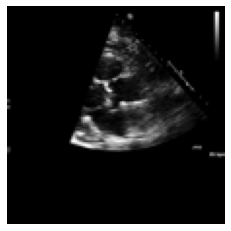

In [27]:
ShowGrayscaleImage(target_image/255)


In [28]:
#Make predictions
this_image_input = normalize_to_be_the_same_value_seen_by_model(target_image)
view_predictions = sess2.run(classify_op_view, feed_dict={x_in_view:[this_image_input]})[0]
view_predicted_label = ViewLabel_to_Name_mapping[np.argmax(view_predictions)]

print('Predicted view label: {}'.format(view_predicted_label))


Predicted view label: PLAX
